# TensorFlow 2.0 alpha - Text Generation with a character-based RNN
### Given a sequence of characters, train a model to predict the next character in the sequence

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import os
import time

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Download Dataset - Shakespeare

In [4]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


#### Look at the Text

In [5]:
# Read - then decode for py2 compat.

text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [6]:
# print first 300 characters

print(text[:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


#### Number of unique characters in the file

In [7]:
vocab = sorted(set(text))

print('{} Unique Characters'.format(len(vocab)))

65 Unique Characters


# Process the Text
### Vectorize the Text - map strings to numerical representation
#### Create 2 lookup tables - characters to numbers, and numbers to characters

In [8]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

# Now have integer representation for each character

print('{')
for char,_ in zip(char2idx, range(20)):
    print(' {:4s}: {:3d},'.format(repr(char), char2idx[char]))

print(' ...\n}')

{
 '\n':   0,
 ' ' :   1,
 '!' :   2,
 '$' :   3,
 '&' :   4,
 "'" :   5,
 ',' :   6,
 '-' :   7,
 '.' :   8,
 '3' :   9,
 ':' :  10,
 ';' :  11,
 '?' :  12,
 'A' :  13,
 'B' :  14,
 'C' :  15,
 'D' :  16,
 'E' :  17,
 'F' :  18,
 'G' :  19,
 ...
}


#### Show the first 20 characters from the Text - mapped to integers

In [10]:
print('{} ---- characters mapped to int ---- > {}'.format(repr(text[:20]), text_as_int[:20]))

'First Citizen:\nBefor' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56]


### Prediction Task
#### RNNs have an internal state that depends on previously seen elements
## Create Training Examples and Targets
#### Divide Text into example sequences of seq_length characters - Targets contain same length, but shift 1 space to the right
#### Will need to break Text into chunks of seq_length+1 - use tf.data.Dataset.from_tensor_slices (convert text vector to character indices)

In [11]:
# max length sentence wanted for a single input

seq_length = 100
examples_per_epoch = len(text)//seq_length

# create training examples, targets

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

F
i
r
s
t


#### batch - method allows converting individual characters to sequences of desired length

In [14]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


#### For each sequence - duplicate, and shift - to form input and target text - using map

In [15]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

#### Print first examples, input and target values

In [16]:
for input_example, target_example in dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data: ', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data:  'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [18]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:4d}'.format(i))
    print(' input: {} ({:s})'.format(input_idx, repr(idx2char[input_idx])))
    print(' expected output: {} ({:s})'.format(target_idx, repr(idx2char[target_idx])))

Step    0
 input: 18 ('F')
 expected output: 47 ('i')
Step    1
 input: 47 ('i')
 expected output: 56 ('r')
Step    2
 input: 56 ('r')
 expected output: 57 ('s')
Step    3
 input: 57 ('s')
 expected output: 58 ('t')
Step    4
 input: 58 ('t')
 expected output: 1 (' ')


### Create Training Batches
#### Shuffle and Pack manageable sequences into Training Batches

In [19]:
BATCH_SIZE = 64

# TF attempts to shuffle data in Buffers - as opposed to shuffling entire dataset

BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

# Build Model
### Use tf.keras.Sequential - define model using 3 layers
#### (1) Embedding - input layer, trainable table mapping numbers of each character to vector (embedding_dim)
#### (2) GRU - type of RNN, of size units=rnn_units (could also use LSTM layer)
#### (3) Dense - output layer, with vocab_size outputs

In [20]:
# length of vocabulary in chars - embedding dimension - number of RNN units

vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [21]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                 batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True,
                            stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    
    return model

model = build_model(vocab_size = len(vocab),
                   embedding_dim = embedding_dim,
                   rnn_units = rnn_units,
                   batch_size = BATCH_SIZE)

#### With each character, model looks up the embedding - runs GRU 1 timestep (embedding as input) - applies Dense layer to generate logits (predicting log-liklihood of next character)

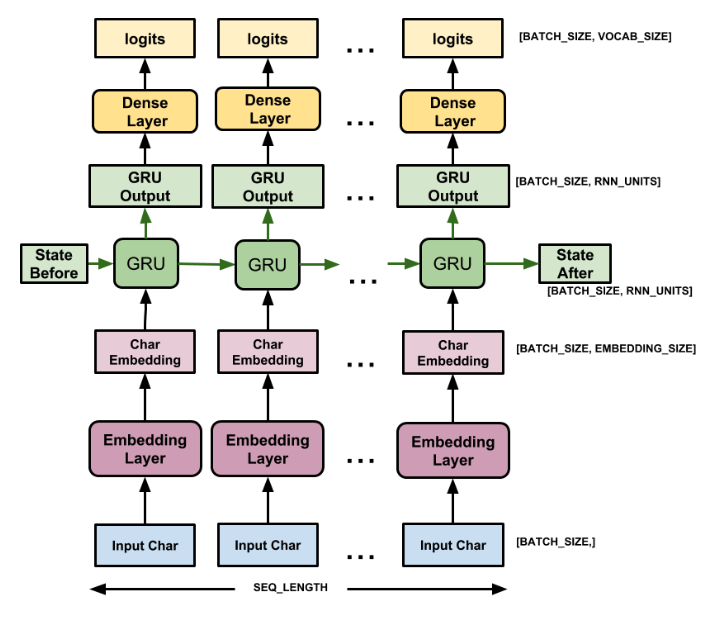

### Try Model
#### Check output shape

In [23]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_prediction = model(input_example_batch)
    print(example_batch_prediction.shape, '# (batch_size, sequence_length, vocab_size)')

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


#### NOTE - to get actual predictions from this model, sample from the output distribution (to get actual character indices) - This distribution is defined by logits over the character vocabulary - IMPORTANT to sample from this distribution (taking argmax would force model to be stuck in a loop)
#### Try the first example in the Batch

In [25]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=1).numpy()

#### This provides (at each timestep) - prediction of the next character index

In [26]:
sampled_indices

array([63, 34, 36, 13, 51, 13,  6,  0, 46, 54, 37,  3, 40, 58,  1, 21, 30,
       48, 32, 23, 31, 21, 63,  2, 49, 62, 58, 64, 25, 57, 13, 31, 43, 51,
       34, 40, 40, 51, 20, 61, 59, 10, 57, 33, 46, 25, 58, 37,  1, 62, 21,
        4, 21, 61, 37,  8, 31, 38, 16, 15, 30, 12, 38, 27, 28, 29, 31, 30,
        1, 26, 53, 18, 35, 50, 33, 63, 58, 11, 25, 27, 31, 41, 58, 18, 63,
       51, 64, 35, 10, 28, 54, 26, 40, 29,  3, 52, 41, 35, 26, 48])

#### Decode - to see Text predicted by the untrained model

In [27]:
print('Input: \n', repr(''.join(idx2char[input_example_batch[0]])))
print()
print('Next Char Predictions: \n', repr(''.join(idx2char[sampled_indices ])))

Input: 
 'OF YORK:\nNo matter, then, who see it;\nI will be satisfied; let me see the writing.\n\nDUKE OF AUMERLE:'

Next Char Predictions: 
 'yVXAmA,\nhpY$bt IRjTKSIy!kxtzMsASemVbbmHwu:sUhMtY xI&IwY.SZDCR?ZOPQSR NoFWlUyt;MOSctFymzW:PpNbQ$ncWNj'


# Train Model
### Add an Optimizer and Loss Function
#### tf.keras.losses.sparse_softmax_crossentropy - loss function, applied to last dimension of the predictions

In [28]:
# model runs logits, set the from_logits tag

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print('Prediction shape: ', example_batch_predictions.shape, '# (batch_size, sequence_length, vocab_size)')
print('Scalar_loss: ', example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65) # (batch_size, sequence_length, vocab_size)
Scalar_loss:  4.1751347


#### Use tf.keras.Model.compile 

In [29]:
model.compile(optimizer='adam', loss=loss)

### Configure Checkpoints
#### Use tf.keras.callbacks.ModelCheckpoint - ensure checkpoints saved during training

In [30]:
# directory for where checkpoints are saved

checkpoint_dir = './training_chaeckpoints'

# name checkpoint files

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute Training
#### GPU would provide faster training

In [31]:
EPOCHS = 5

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/5
172/172 [==============================] - 949s 6s/step - loss: 2.5573
Epoch 2/5
172/172 [==============================] - 1004s 6s/step - loss: 1.8611
Epoch 3/5
172/172 [==============================] - 934s 5s/step - loss: 1.6173
Epoch 4/5
172/172 [==============================] - 1220s 7s/step - loss: 1.4876
Epoch 5/5
172/172 [==============================] - 1166s 7s/step - loss: 1.4063


### Generate Text
#### Because of the RNN state - model only accepts a fixed batch size

In [32]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_chaeckpoints/ckpt_5'

In [34]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


# Prediction Loop
#### Start by choosing a string of text - initialize the RNN state, set the number of characters to generate - Get prediction distribution of the next character (using start string and RNN state)  - use categorical distribution to calculate the index of predicted character, and use predicted character as our next input - RNN state is fed back into model, giving it more context, learning from previously predicted words

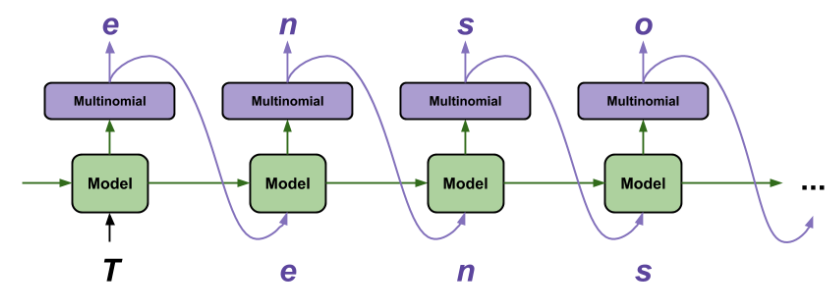

In [40]:
# evaluation step - generate text using learned model

def generate_text(model, start_string):

# number of characters to generate
    
    num_generate = 1000

# convert starting string to numbers    
    
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = []

# low temperatures result in more predictable text    
    
    temperature = 1.0
    
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        
        predictions = tf.squeeze(predictions, 0)

# use categorical distribution to predict word returned by model        
        
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

# pass predicted word as next input to the model        
        
        input_eval = tf.expand_dims([predicted_id], 0)
        
        text_generated.append(idx2char[predicted_id])
    
    return (start_string + ''.join(text_generated))

In [41]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: VRQUHJ&JU;NHzTABUVc&DNj$$WJDUHNPGQFC&G3DQUZSXVD&TXBXGHMX&GU$AKYVADMJjYGZ&?JHSz$;3ONZgJYNUGVVF$NPJ$JGXUSVjKA3zNjDqABZxAMKMHNYQDZE&;OHLZKPqzUWQP!!-$SE,KjVMGQSSjAZVJZjVFXqAPX&Vx$CVVkjCNMJVQSXVZDEqVj&BjZHGOMV$V&MKjKQXSjF3M$$z$VT&xGUDxVYOHJUj&&ZGZJUVEVXZFK3LXD?&XKQADNZOESMZWrGj&UZLzQR&XCHMQYKWAD,NU$FKzqDDJOQJJ3DN$qzDQAQXV!UVLELZA&ZHNJ$ZXAV33jjaHYUJUN3C$KMVNPDzQTqQxZD&N$IjDGC!FCSZVC3qIXHW&QCPQUSzxJX$VZJKDQATWZQNQMQZY3QAVNADVDZZZ3&PQpK$QXUVYOD&vQDXQZVUZDTMK3TQHDSQLYUQRQ3XCSENRFjjDSjJDBG&GZVK?EYZ$jZz33HMZq3DNLSYN$Q;;ZK&Xz$VvUXP3HNHVVq$ZXHOZB$VO3$LJVW;D3SPQXU$QCVZVQOSFHqDNRVDQXZXPQDYBSJDMZQNSQKjOQVQqAMKVIKKSVMAFDVFXJXSUqBQZSWUqHRV3QR&MFSFAXVMJGVNMXkYJLDMQDL$&MPOJjY3VSxwj3A&FYMJjJXQZjP!$FxYAKNAcLZVXQDPKZ$U;XV:3VZUB&VLzXAjMVXA3&xWGkJ$X$xQM$MNK&?ZFZqGHGKAQOXX?Nxj3ZPNXKDZOUCFXMGx3UDjAZXXKRZQqQKjX3K&HjXVZqOFCXQ3zIjAxKSM.VN:AMMJjNVVDNXVNPV&MQJXZINDKYX!gF!!NKVTCEJ&UzM3U3GTWGX3&qDjqHQRUJMHQVTXNCAQNKGQzHJD&NN$JDjLXQQUVjMQANwX3qVHB;X$ZXAUKMJCHENSQWYD&B$MqXAjMUSjiVVzVPNMAI$DQUzsU?bZjTMUTZLQYUZS&R?G

#### Easiest approach to improving the model is longer Training - more Epochs
#### Could also start with a different string - add another RNN layer - adjust temperature
# Advanced - Customized Training
#### Manually unpack the training loop - use tf.GradientTape to track gradients

In [43]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim = embedding_dim,
    rnn_units = rnn_units,
    batch_size = BATCH_SIZE)

In [44]:
optimizer = tf.keras.optimizers.Adam()

In [47]:
@tf.function
def train_step(inp, target):
    with tf.GradientTape() as tape:
        predictions = model(inp)
        loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(target, predictions))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [48]:
# training step

EPOCHS = 8 

for epoch in range(EPOCHS):
    start = time.time()
    
    for (batch_n, (inp, target)) in enumerate(dataset):
        loss = train_step(inp, target)
        
        if batch_n % 100 == 0:
            template = 'Epoch {} Batch {} Loss{}'
            print(template.format(epoch+1, batch_n, loss))
            
    if (epoch + 1) % 4 == 0 :
        model.save_weights(checkpoint_prefix.format(epoch=epoch))
        
    print('Epoch {} loss {:.4f}'.format(epoch+1, loss))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss8.455743789672852
Epoch 1 Batch 100 Loss4.096637725830078
Epoch 1 loss 4.0620
Time taken for 1 epoch 1250.2070581912994 sec

Epoch 2 Batch 0 Loss4.100394248962402
Epoch 2 Batch 100 Loss4.066242218017578
Epoch 2 loss 4.0543
Time taken for 1 epoch 1234.1328527927399 sec

Epoch 3 Batch 0 Loss4.0854997634887695
Epoch 3 Batch 100 Loss4.113528251647949
Epoch 3 loss 4.1287
Time taken for 1 epoch 1209.63671708107 sec

Epoch 4 Batch 0 Loss4.1536149978637695
Epoch 4 Batch 100 Loss4.114127159118652
Epoch 4 loss 4.1374
Time taken for 1 epoch 1209.9327371120453 sec

Epoch 5 Batch 0 Loss4.1596269607543945
Epoch 5 Batch 100 Loss4.126977920532227
Epoch 5 loss 4.1443
Time taken for 1 epoch 1213.7171988487244 sec

Epoch 6 Batch 0 Loss4.166986465454102
Epoch 6 Batch 100 Loss4.134246826171875
Epoch 6 loss 4.1443
Time taken for 1 epoch 1199.667396068573 sec

Epoch 7 Batch 0 Loss4.166986465454102
Epoch 7 Batch 100 Loss4.134246826171875
Epoch 7 loss 4.1443
Time taken for 1 epoch 1160.7487